In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the balanced training dataset
print("Loading balanced training dataset...")
balanced_train = pd.read_csv("balanced_train_dataset_with_text.csv")

# Load validation and test datasets
print("Loading validation and test datasets...")
val_dataset = pd.read_csv("val_dataset_with_text.csv")
test_dataset = pd.read_csv("test_dataset_with_text.csv")

# Display basic information about the datasets
print("\nDataset shapes:")
print(f"Balanced training: {balanced_train.shape}")
print(f"Validation: {val_dataset.shape}")
print(f"Test: {test_dataset.shape}")

# Check class distribution in each dataset
print("\nClass distribution:")
print("Training:")
print(balanced_train['label'].value_counts())
print("\nValidation:")
print(val_dataset['label'].value_counts())
print("\nTest:")
print(test_dataset['label'].value_counts())

# Check language distribution in the training set
print("\nLanguage distribution in training set:")
print(balanced_train['language'].value_counts())

# Display some sample rows
print("\nSample rows from balanced training dataset:")
print(balanced_train[['label', 'title', 'text', 'language']].head(3))

Loading balanced training dataset...
Loading validation and test datasets...

Dataset shapes:
Balanced training: (1538, 33)
Validation: (407, 33)
Test: (407, 33)

Class distribution:
Training:
label
Fake    769
Real    769
Name: count, dtype: int64

Validation:
label
Fake    256
Real    151
Name: count, dtype: int64

Test:
label
Fake    256
Real    151
Name: count, dtype: int64

Language distribution in training set:
language
english    1492
german       41
ignore        2
french        2
spanish       1
Name: count, dtype: int64

Sample rows from balanced training dataset:
  label                                          title  \
0  Fake  mike pence says shalom to israels republicans   
1  Fake             re babylon mystery religion series   
2  Fake                                       no title   

                                                text language  
0  published on jun   by the rays of reason  mill...  english  
1  parts    obelisks  the cross origins httpswwwy...  engl

In [ ]:
# First, let's handle the multi-language issue and preprocess the text data
# We'll create a function to preprocess text
def preprocess_text(text, language):
    """
    Preprocess text data based on language
    
    Parameters:
    -----------
    text : str
        The text to be preprocessed
    language : str
        The language of the text
    
    Returns:
    --------
    str
        Preprocessed text
    """
    # First check if text is NaN or None
    if pd.isna(text) or text is None:
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Return the preprocessed text
    return text

# Apply preprocessing to title and text in all datasets
print("Preprocessing text data...")

# Preprocess training data
balanced_train['processed_title'] = balanced_train.apply(
    lambda row: preprocess_text(row['title'], row['language']), axis=1
)
balanced_train['processed_text'] = balanced_train.apply(
    lambda row: preprocess_text(row['text'], row['language']), axis=1
)

# Preprocess validation data
val_dataset['processed_title'] = val_dataset.apply(
    lambda row: preprocess_text(row['title'], row['language']), axis=1
)
val_dataset['processed_text'] = val_dataset.apply(
    lambda row: preprocess_text(row['text'], row['language']), axis=1
)

# Preprocess test data
test_dataset['processed_title'] = test_dataset.apply(
    lambda row: preprocess_text(row['title'], row['language']), axis=1
)
test_dataset['processed_text'] = test_dataset.apply(
    lambda row: preprocess_text(row['text'], row['language']), axis=1
)

# Combine title and text for feature extraction
balanced_train['combined_text'] = balanced_train['processed_title'] + ' ' + balanced_train['processed_text']
val_dataset['combined_text'] = val_dataset['processed_title'] + ' ' + val_dataset['processed_text']
test_dataset['combined_text'] = test_dataset['processed_title'] + ' ' + test_dataset['processed_text']

# Check result
print("\nSample of preprocessed text:")
print(balanced_train[['processed_title', 'processed_text', 'combined_text']].head(2))

# Check for any missing values
print("\nMissing values in processed columns:")
print(balanced_train[['processed_title', 'processed_text', 'combined_text']].isna().sum())

Preprocessing text data...

Sample of preprocessed text:
                                 processed_title  \
0  mike pence says shalom to israels republicans   
1             re babylon mystery religion series   

                                      processed_text  \
0  published on jun   by the rays of reason  mill...   
1  parts    obelisks  the cross origins httpswwwy...   

                                       combined_text  
0  mike pence says shalom to israels republicans ...  
1  re babylon mystery religion series parts    ob...  

Missing values in processed columns:
processed_title    0
processed_text     0
combined_text      0
dtype: int64


In [5]:
# Define a function to create TF-IDF features based on language
def create_language_specific_tfidf(data, ngram_range=(1, 1), max_features=5000):
    """
    Create language-specific TF-IDF features
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing text data and language information
    ngram_range : tuple, default=(1, 1)
        The lower and upper boundary of the range of n-values for different
        word n-grams or char n-grams to be extracted
    max_features : int, default=5000
        Maximum number of features to retain
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with TF-IDF features for each language
    """
    # Get unique languages
    languages = data['language'].unique()
    
    # Create a dictionary to store TF-IDF vectorizers for each language
    tfidf_vectorizers = {}
    
    # Create a list to store the transformed data
    transformed_data_list = []
    
    # For each language, create a separate TF-IDF vectorizer
    for lang in languages:
        # Subset data for this language
        lang_data = data[data['language'] == lang]
        
        if len(lang_data) > 0:
            print(f"  Processing language: {lang} with {len(lang_data)} samples")
            
            # Set safe values for min_df and max_df based on dataset size
            n_samples = len(lang_data)
            # For small datasets, use absolute counts instead of proportions
            if n_samples < 50:
                min_df_value = 1
                max_df_value = n_samples  # All documents
            else:
                min_df_value = 1
                max_df_value = 0.99  # 99% of documents
            
            # Create a TF-IDF vectorizer for this language with more flexible parameters
            tfidf_vectorizer = TfidfVectorizer(
                ngram_range=ngram_range,
                max_features=max_features,
                sublinear_tf=True,     # Apply sublinear tf scaling (1 + log(tf))
                min_df=min_df_value,   # Minimum document frequency: depends on dataset size
                max_df=max_df_value,   # Maximum document frequency: depends on dataset size
                strip_accents='unicode',
                use_idf=True,
                smooth_idf=True,
                stop_words='english' if lang == 'english' else None  # Only use English stopwords for English text
            )
            
            try:
                # Fit and transform the data
                tfidf_matrix = tfidf_vectorizer.fit_transform(lang_data['combined_text'])
                
                # Convert to DataFrame
                feature_names = tfidf_vectorizer.get_feature_names_out()
                lang_tfidf_df = pd.DataFrame(
                    tfidf_matrix.toarray(),
                    index=lang_data.index,
                    columns=[f'tfidf_{lang}_{name}' for name in feature_names]
                )
                
                # Add to the list
                transformed_data_list.append(lang_tfidf_df)
                
                # Store the vectorizer
                tfidf_vectorizers[lang] = tfidf_vectorizer
                
            except ValueError as e:
                print(f"Error processing language {lang}: {e}")
                # Skip this language if there's an error
                continue
    
    # Combine all transformed data
    if transformed_data_list:
        all_tfidf_df = pd.concat(transformed_data_list, axis=1)
        all_tfidf_df = all_tfidf_df.reindex(data.index, fill_value=0)  # Reindex to match original data
        return all_tfidf_df, tfidf_vectorizers
    else:
        return pd.DataFrame(index=data.index), {}

# Test our function with 1-gram on a small subset first
print("Testing TF-IDF features creation on a small subset with 1-gram...")
subset_size = 100
subset_data = balanced_train.head(subset_size)
subset_tfidf_1gram, subset_vectorizers_1gram = create_language_specific_tfidf(
    subset_data, 
    ngram_range=(1, 1), 
    max_features=1000
)

print(f"\nCreated {subset_tfidf_1gram.shape[1]} TF-IDF features from {subset_size} samples")
print("Sample of TF-IDF features:")
if not subset_tfidf_1gram.empty and subset_tfidf_1gram.shape[1] > 0:
    print(subset_tfidf_1gram.iloc[:2, :5])  # Display first 2 rows and 5 columns
else:
    print("No features were created.")

Testing TF-IDF features creation on a small subset with 1-gram...
  Processing language: english with 96 samples
  Processing language: ignore with 2 samples
  Processing language: german with 1 samples
  Processing language: spanish with 1 samples

Created 1668 TF-IDF features from 100 samples
Sample of TF-IDF features:
   tfidf_english_abedin  tfidf_english_able  tfidf_english_accept  \
0                   0.0                 0.0                   0.0   
1                   0.0                 0.0                   0.0   

   tfidf_english_access  tfidf_english_according  
0                   0.0                      0.0  
1                   0.0                      0.0  


In [6]:
# Now create the actual TF-IDF features for the entire training dataset
print("Creating TF-IDF features for the entire training dataset...")

# Create 1-gram features
print("\nCreating 1-gram TF-IDF features...")
tfidf_1gram, vectorizers_1gram = create_language_specific_tfidf(
    balanced_train, 
    ngram_range=(1, 1), 
    max_features=10000  # Increase max_features for the full dataset
)

print(f"\nCreated {tfidf_1gram.shape[1]} 1-gram TF-IDF features")

# Create 2-gram features
print("\nCreating 1-2 gram TF-IDF features...")
tfidf_2gram, vectorizers_2gram = create_language_specific_tfidf(
    balanced_train, 
    ngram_range=(1, 2),  # Include both 1-grams and 2-grams
    max_features=15000  # Allow more features for bigrams
)

print(f"\nCreated {tfidf_2gram.shape[1]} 1-2 gram TF-IDF features")

# Display the shape of the features and some examples
print("\nDimensions of feature matrices:")
print(f"1-gram TF-IDF: {tfidf_1gram.shape}")
print(f"1-2 gram TF-IDF: {tfidf_2gram.shape}")

# Show some sample 2-gram feature names (if they exist)
if not tfidf_2gram.empty and tfidf_2gram.shape[1] > 0:
    bigram_features = [col for col in tfidf_2gram.columns if '_' in col.split('_', 2)[-1]]
    if bigram_features:
        print("\nSample of 2-gram features:")
        for feature in bigram_features[:5]:
            print(f"- {feature}")

Creating TF-IDF features for the entire training dataset...

Creating 1-gram TF-IDF features...
  Processing language: english with 1492 samples
  Processing language: ignore with 2 samples
  Processing language: german with 41 samples
  Processing language: spanish with 1 samples
  Processing language: french with 2 samples

Created 14416 1-gram TF-IDF features

Creating 1-2 gram TF-IDF features...
  Processing language: english with 1492 samples
  Processing language: ignore with 2 samples
  Processing language: german with 41 samples
  Processing language: spanish with 1 samples
  Processing language: french with 2 samples

Created 29638 1-2 gram TF-IDF features

Dimensions of feature matrices:
1-gram TF-IDF: (1538, 14416)
1-2 gram TF-IDF: (1538, 29638)

Sample of 2-gram features:
- tfidf_english____
- tfidf_english_dufas_duck
- tfidf_english_httpwwwinfowarscomwpcontentuploadsbrainforceejpg httpwwwinfowarsstorecomhealthandwellnessinfowarslifebrainforcehtmlimstzrwuutm_campaigninfowar

In [7]:
# Function to apply fitted TF-IDF vectorizers to new data
def apply_language_tfidf_vectorizers(data, vectorizers):
    """
    Apply previously fitted TF-IDF vectorizers to new data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing text data and language information
    vectorizers : dict
        Dictionary of fitted TF-IDF vectorizers for each language
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with TF-IDF features for each language
    """
    # Create a list to store the transformed data
    transformed_data_list = []
    
    # For each language in the vectorizers
    for lang, vectorizer in vectorizers.items():
        # Subset data for this language
        lang_data = data[data['language'] == lang]
        
        if len(lang_data) > 0:
            print(f"  Transforming language: {lang} with {len(lang_data)} samples")
            
            # Transform the data using the fitted vectorizer
            try:
                tfidf_matrix = vectorizer.transform(lang_data['combined_text'])
                
                # Convert to DataFrame
                feature_names = vectorizer.get_feature_names_out()
                lang_tfidf_df = pd.DataFrame(
                    tfidf_matrix.toarray(),
                    index=lang_data.index,
                    columns=[f'tfidf_{lang}_{name}' for name in feature_names]
                )
                
                # Add to the list
                transformed_data_list.append(lang_tfidf_df)
            except Exception as e:
                print(f"Error transforming language {lang}: {e}")
                # Skip this language if there's an error
                continue
    
    # Combine all transformed data
    if transformed_data_list:
        all_tfidf_df = pd.concat(transformed_data_list, axis=1)
        
        # Fill missing columns with zeros (for features present in training but not in this data)
        missing_columns = set()
        for lang, vectorizer in vectorizers.items():
            for feature in vectorizer.get_feature_names_out():
                col = f'tfidf_{lang}_{feature}'
                if col not in all_tfidf_df.columns:
                    missing_columns.add(col)
        
        # Add missing columns with zeros
        for col in missing_columns:
            all_tfidf_df[col] = 0
            
        # Reindex to match original data
        all_tfidf_df = all_tfidf_df.reindex(data.index, fill_value=0)
        
        return all_tfidf_df
    else:
        return pd.DataFrame(index=data.index)

# Apply the vectorizers to validation and test data
print("Applying TF-IDF vectorizers to validation and test data...")

# Apply 1-gram vectorizers
print("\nApplying 1-gram vectorizers...")
val_tfidf_1gram = apply_language_tfidf_vectorizers(val_dataset, vectorizers_1gram)
test_tfidf_1gram = apply_language_tfidf_vectorizers(test_dataset, vectorizers_1gram)

print(f"\nValidation 1-gram TF-IDF features shape: {val_tfidf_1gram.shape}")
print(f"Test 1-gram TF-IDF features shape: {test_tfidf_1gram.shape}")

# Apply 2-gram vectorizers
print("\nApplying 1-2 gram vectorizers...")
val_tfidf_2gram = apply_language_tfidf_vectorizers(val_dataset, vectorizers_2gram)
test_tfidf_2gram = apply_language_tfidf_vectorizers(test_dataset, vectorizers_2gram)

print(f"\nValidation 1-2 gram TF-IDF features shape: {val_tfidf_2gram.shape}")
print(f"Test 1-2 gram TF-IDF features shape: {test_tfidf_2gram.shape}")

Applying TF-IDF vectorizers to validation and test data...

Applying 1-gram vectorizers...
  Transforming language: english with 394 samples
  Transforming language: german with 13 samples
  Transforming language: english with 388 samples
  Transforming language: ignore with 1 samples
  Transforming language: german with 18 samples

Validation 1-gram TF-IDF features shape: (407, 14416)
Test 1-gram TF-IDF features shape: (407, 14416)

Applying 1-2 gram vectorizers...
  Transforming language: english with 394 samples
  Transforming language: german with 13 samples
  Transforming language: english with 388 samples
  Transforming language: ignore with 1 samples
  Transforming language: german with 18 samples

Validation 1-2 gram TF-IDF features shape: (407, 29638)
Test 1-2 gram TF-IDF features shape: (407, 29638)


In [10]:
# Check for and handle any NaN values in the feature sets
for feature_set_name, feature_set in feature_sets.items():
    # Check if there are any NaN values
    nan_count = feature_set.isna().sum().sum()
    if nan_count > 0:
        print(f"Found {nan_count} NaN values in {feature_set_name}. Filling with zeros.")
        # Fill NaN values with zeros
        feature_sets[feature_set_name] = feature_set.fillna(0)

# Convert target labels to binary format (0 for 'Fake', 1 for 'Real')
y_train = (balanced_train['label'] == 'Real').astype(int)
y_val = (val_dataset['label'] == 'Real').astype(int)
y_test = (test_dataset['label'] == 'Real').astype(int)

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear'  # Change solver to handle high-dimensional data better
    )
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Dictionary to store results
results = {}

# Perform cross-validation for each model and feature set
print("Performing cross-validation...")

for model_name, model in models.items():
    for feature_name, features in feature_sets.items():
        print(f"\nEvaluating {model_name} with {feature_name}")
        
        # Ensure features are dense if necessary for the model
        if model_name == 'Logistic Regression' and isinstance(features, pd.DataFrame):
            # Convert to numpy array
            X = features.values
        else:
            X = features
            
        # Perform cross-validation
        try:
            cv_results = cross_validate(
                model,
                X,
                y_train,
                cv=cv,
                scoring=scoring,
                return_train_score=False,
                error_score='raise'  # Raise error for debugging
            )
            
            # Calculate mean and standard deviation of the scores
            mean_scores = {}
            std_scores = {}
            
            for metric_key in cv_results.keys():
                if metric_key.startswith('test_'):
                    metric_name = metric_key
                    mean_scores[metric_name] = np.mean(cv_results[metric_key])
                    std_scores[f"{metric_name}_std"] = np.std(cv_results[metric_key])
            
            # Store results
            results[f"{model_name} - {feature_name}"] = {**mean_scores, **std_scores}
            
            # Print results
            print(f"  Accuracy: {mean_scores['test_accuracy']:.4f} ± {std_scores['test_accuracy_std']:.4f}")
            print(f"  Precision: {mean_scores['test_precision']:.4f} ± {std_scores['test_precision_std']:.4f}")
            print(f"  Recall: {mean_scores['test_recall']:.4f} ± {std_scores['test_recall_std']:.4f}")
            print(f"  F1: {mean_scores['test_f1']:.4f} ± {std_scores['test_f1_std']:.4f}")
            print(f"  ROC AUC: {mean_scores['test_roc_auc']:.4f} ± {std_scores['test_roc_auc_std']:.4f}")
            
        except Exception as e:
            print(f"  Error during cross-validation: {e}")
            print("  Skipping this model-feature combination")

# Create a DataFrame of results for easier comparison (only for successful runs)
if results:
    results_df = pd.DataFrame(results).T
    print("\nCross-validation results summary:")
    columns_to_display = [col for col in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc'] 
                         if any(col in result for result in results.values())]
    print(results_df[columns_to_display])
else:
    print("\nNo successful cross-validation results to display.")

Found 7092184 NaN values in 1-gram TF-IDF. Filling with zeros.
Found 22661551 NaN values in 1-2 gram TF-IDF. Filling with zeros.
Performing cross-validation...

Evaluating Random Forest with 1-gram TF-IDF
  Accuracy: 0.8661 ± 0.0031
  Precision: 0.8872 ± 0.0210
  Recall: 0.8400 ± 0.0205
  F1: 0.8625 ± 0.0019
  ROC AUC: 0.9367 ± 0.0076

Evaluating Random Forest with 1-2 gram TF-IDF
  Accuracy: 0.8570 ± 0.0060
  Precision: 0.8887 ± 0.0344
  Recall: 0.8192 ± 0.0331
  F1: 0.8513 ± 0.0061
  ROC AUC: 0.9350 ± 0.0081

Evaluating Logistic Regression with 1-gram TF-IDF
  Accuracy: 0.8349 ± 0.0168
  Precision: 0.8423 ± 0.0366
  Recall: 0.8270 ± 0.0117
  F1: 0.8339 ± 0.0124
  ROC AUC: 0.9156 ± 0.0123

Evaluating Logistic Regression with 1-2 gram TF-IDF
  Accuracy: 0.8576 ± 0.0124
  Precision: 0.8767 ± 0.0321
  Recall: 0.8348 ± 0.0293
  F1: 0.8543 ± 0.0116
  ROC AUC: 0.9273 ± 0.0109

Cross-validation results summary:
                                       test_accuracy  test_precision  \
Random Fo

In [13]:
# Import clone function for copying models
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

Training final models on full training data and evaluating on validation set...

Training Random Forest with 1-gram TF-IDF
  Validation Accuracy: 0.7641
  Validation Precision: 0.7477
  Validation Recall: 0.5497
  Validation F1: 0.6336
  Validation ROC AUC: 0.8350

  Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       256
           1       0.75      0.55      0.63       151

    accuracy                           0.76       407
   macro avg       0.76      0.72      0.73       407
weighted avg       0.76      0.76      0.75       407



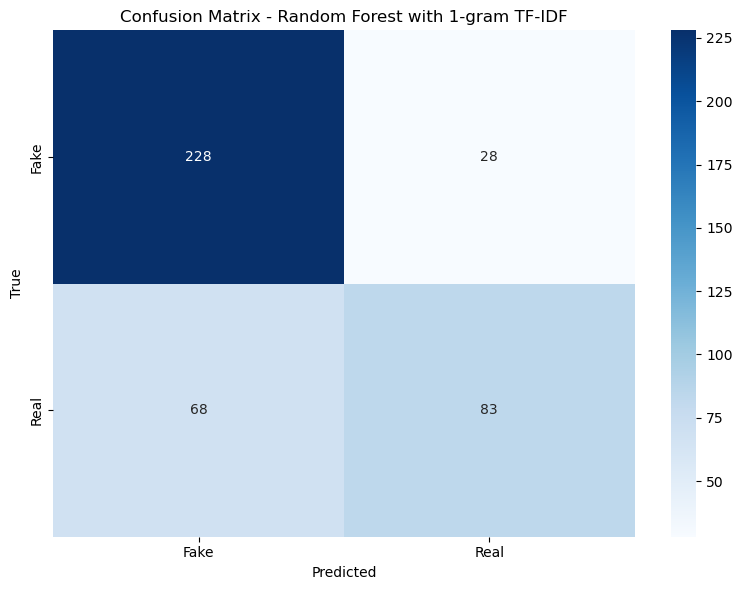


Training Random Forest with 1-2 gram TF-IDF
  Validation Accuracy: 0.7838
  Validation Precision: 0.8539
  Validation Recall: 0.5033
  Validation F1: 0.6333
  Validation ROC AUC: 0.8606

  Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       256
           1       0.85      0.50      0.63       151

    accuracy                           0.78       407
   macro avg       0.81      0.73      0.74       407
weighted avg       0.80      0.78      0.77       407



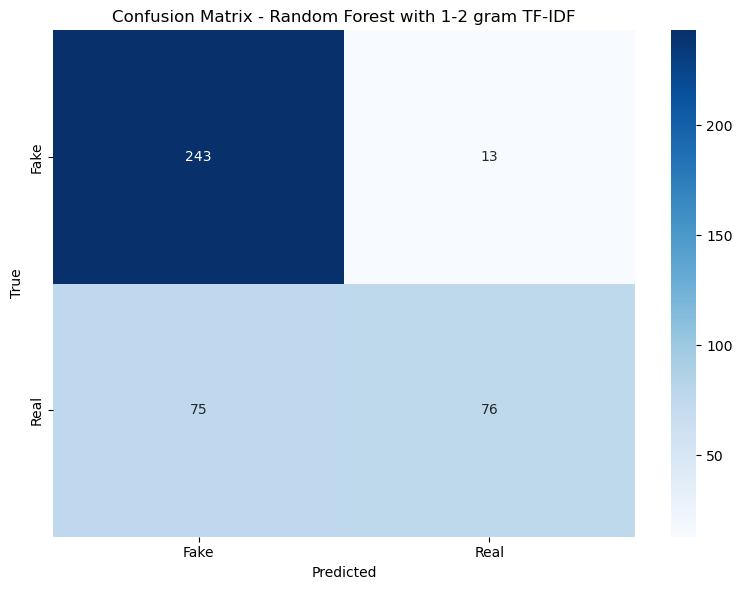


Training Logistic Regression with 1-gram TF-IDF
  Validation Accuracy: 0.7592
  Validation Precision: 0.6934
  Validation Recall: 0.6291
  Validation F1: 0.6597
  Validation ROC AUC: 0.8310

  Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       256
           1       0.69      0.63      0.66       151

    accuracy                           0.76       407
   macro avg       0.74      0.73      0.74       407
weighted avg       0.76      0.76      0.76       407



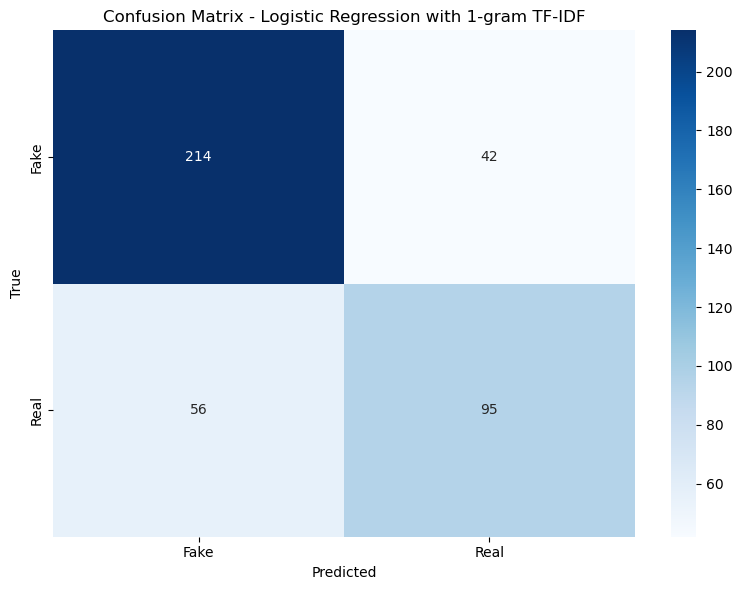


Training Logistic Regression with 1-2 gram TF-IDF
  Validation Accuracy: 0.7838
  Validation Precision: 0.7368
  Validation Recall: 0.6490
  Validation F1: 0.6901
  Validation ROC AUC: 0.8485

  Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       256
           1       0.74      0.65      0.69       151

    accuracy                           0.78       407
   macro avg       0.77      0.76      0.76       407
weighted avg       0.78      0.78      0.78       407



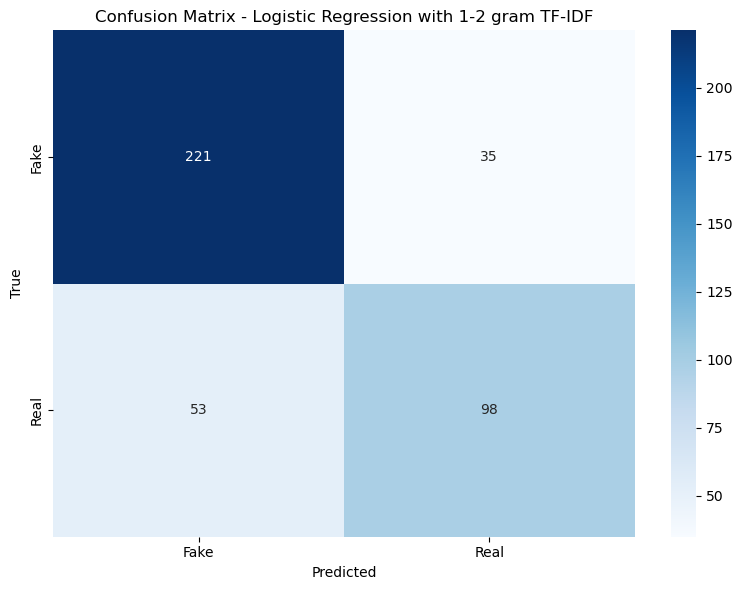


Validation results summary:
                                       accuracy  precision    recall  \
Random Forest - 1-gram TF-IDF          0.764128   0.747748  0.549669   
Random Forest - 1-2 gram TF-IDF        0.783784   0.853933  0.503311   
Logistic Regression - 1-gram TF-IDF    0.759214   0.693431  0.629139   
Logistic Regression - 1-2 gram TF-IDF  0.783784   0.736842  0.649007   

                                             f1   roc_auc  
Random Forest - 1-gram TF-IDF          0.633588  0.835019  
Random Forest - 1-2 gram TF-IDF        0.633333  0.860643  
Logistic Regression - 1-gram TF-IDF    0.659722  0.830971  
Logistic Regression - 1-2 gram TF-IDF  0.690141  0.848484  

Best model based on validation F1 score: Logistic Regression - 1-2 gram TF-IDF
F1 score: 0.6901


In [16]:
# Import clone function for copying models
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

# Train final models on the full training data and evaluate on validation set
print("Training final models on full training data and evaluating on validation set...")

# Dictionary to store final models and their evaluation metrics
final_models = {}
validation_results = {}

for model_name, model in models.items():
    for feature_name, features in feature_sets.items():
        print(f"\nTraining {model_name} with {feature_name}")
        
        # Train the model on full training data
        model_copy = clone(model)  # Create a fresh copy of the model
        
        # Use the training features
        X_train = feature_sets[feature_name]
        
        # Ensure no NaN values
        X_train = X_train.fillna(0)
        
        # Fit the model
        # Using numpy array to avoid feature names issues
        model_copy.fit(X_train.values, y_train)
        
        # Store the trained model
        final_models[f"{model_name} - {feature_name}"] = model_copy
        
        # Get validation features
        if feature_name == '1-gram TF-IDF':
            X_val = val_tfidf_1gram
        else:  # '1-2 gram TF-IDF'
            X_val = val_tfidf_2gram
            
        # Ensure no NaN values and convert to numpy array
        X_val = X_val.fillna(0).values
        
        # Make predictions on validation set
        y_val_pred = model_copy.predict(X_val)
        y_val_prob = model_copy.predict_proba(X_val)[:, 1]  # Probability of 'Real' class
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')
        
        # Calculate ROC AUC
        try:
            roc_auc = roc_auc_score(y_val, y_val_prob)
        except Exception as e:
            print(f"  Error calculating ROC AUC: {e}")
            roc_auc = None
            
        # Store validation results
        validation_results[f"{model_name} - {feature_name}"] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
        
        # Print validation results
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Validation Precision: {precision:.4f}")
        print(f"  Validation Recall: {recall:.4f}")
        print(f"  Validation F1: {f1:.4f}")
        if roc_auc is not None:
            print(f"  Validation ROC AUC: {roc_auc:.4f}")
        
        # Generate and print classification report
        print("\n  Classification Report:")
        print(classification_report(y_val, y_val_pred))
        
        # Generate confusion matrix
        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Fake', 'Real'],
                   yticklabels=['Fake', 'Real'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name} with {feature_name}')
        plt.tight_layout()
        plt.show()

# Create a DataFrame of validation results for easier comparison
validation_df = pd.DataFrame(validation_results).T
print("\nValidation results summary:")
print(validation_df)

# Determine the best model based on F1 score
best_model_name = validation_df['f1'].idxmax()
print(f"\nBest model based on validation F1 score: {best_model_name}")
print(f"F1 score: {validation_df.loc[best_model_name, 'f1']:.4f}")

Evaluating the best model on the test set...

Test results for Logistic Regression - 1-2 gram TF-IDF:
  Test Accuracy: 0.8157
  Test Precision: 0.7754
  Test Recall: 0.7086
  Test F1: 0.7405
  Test ROC AUC: 0.8822

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       256
           1       0.78      0.71      0.74       151

    accuracy                           0.82       407
   macro avg       0.81      0.79      0.80       407
weighted avg       0.81      0.82      0.81       407



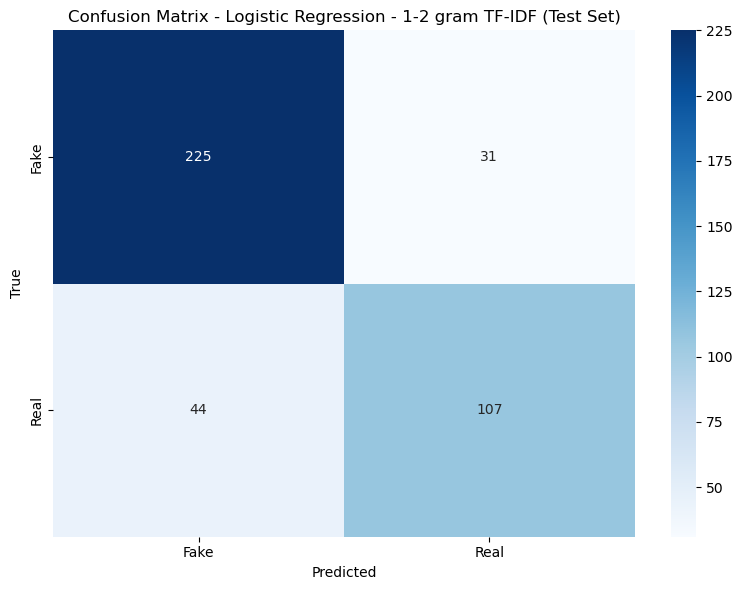


Top 20 Most Influential Features:
                             Feature  Coefficient
7761           tfidf_english_loading     1.831204
9824             tfidf_english_photo     1.530624
13513            tfidf_english_title     1.497044
782            tfidf_english_article     1.411231
14673        tfidf_english_wikileaks    -1.331636
3894              tfidf_english_duke     1.279650
12362             tfidf_english_snip    -1.265753
280                tfidf_english_afp     1.213219
9954                tfidf_english_pm     1.090933
2455          tfidf_english_comments    -1.060482
10629   tfidf_english_published mins     1.029081
92             tfidf_english_account     1.026349
4948              tfidf_english_food    -1.019009
6723              tfidf_english_isis    -0.990761
9069          tfidf_english_november     0.983371
7646              tfidf_english_lies     0.983075
2446   tfidf_english_comment article     0.975700
4968            tfidf_english_forces     0.972201
14376          

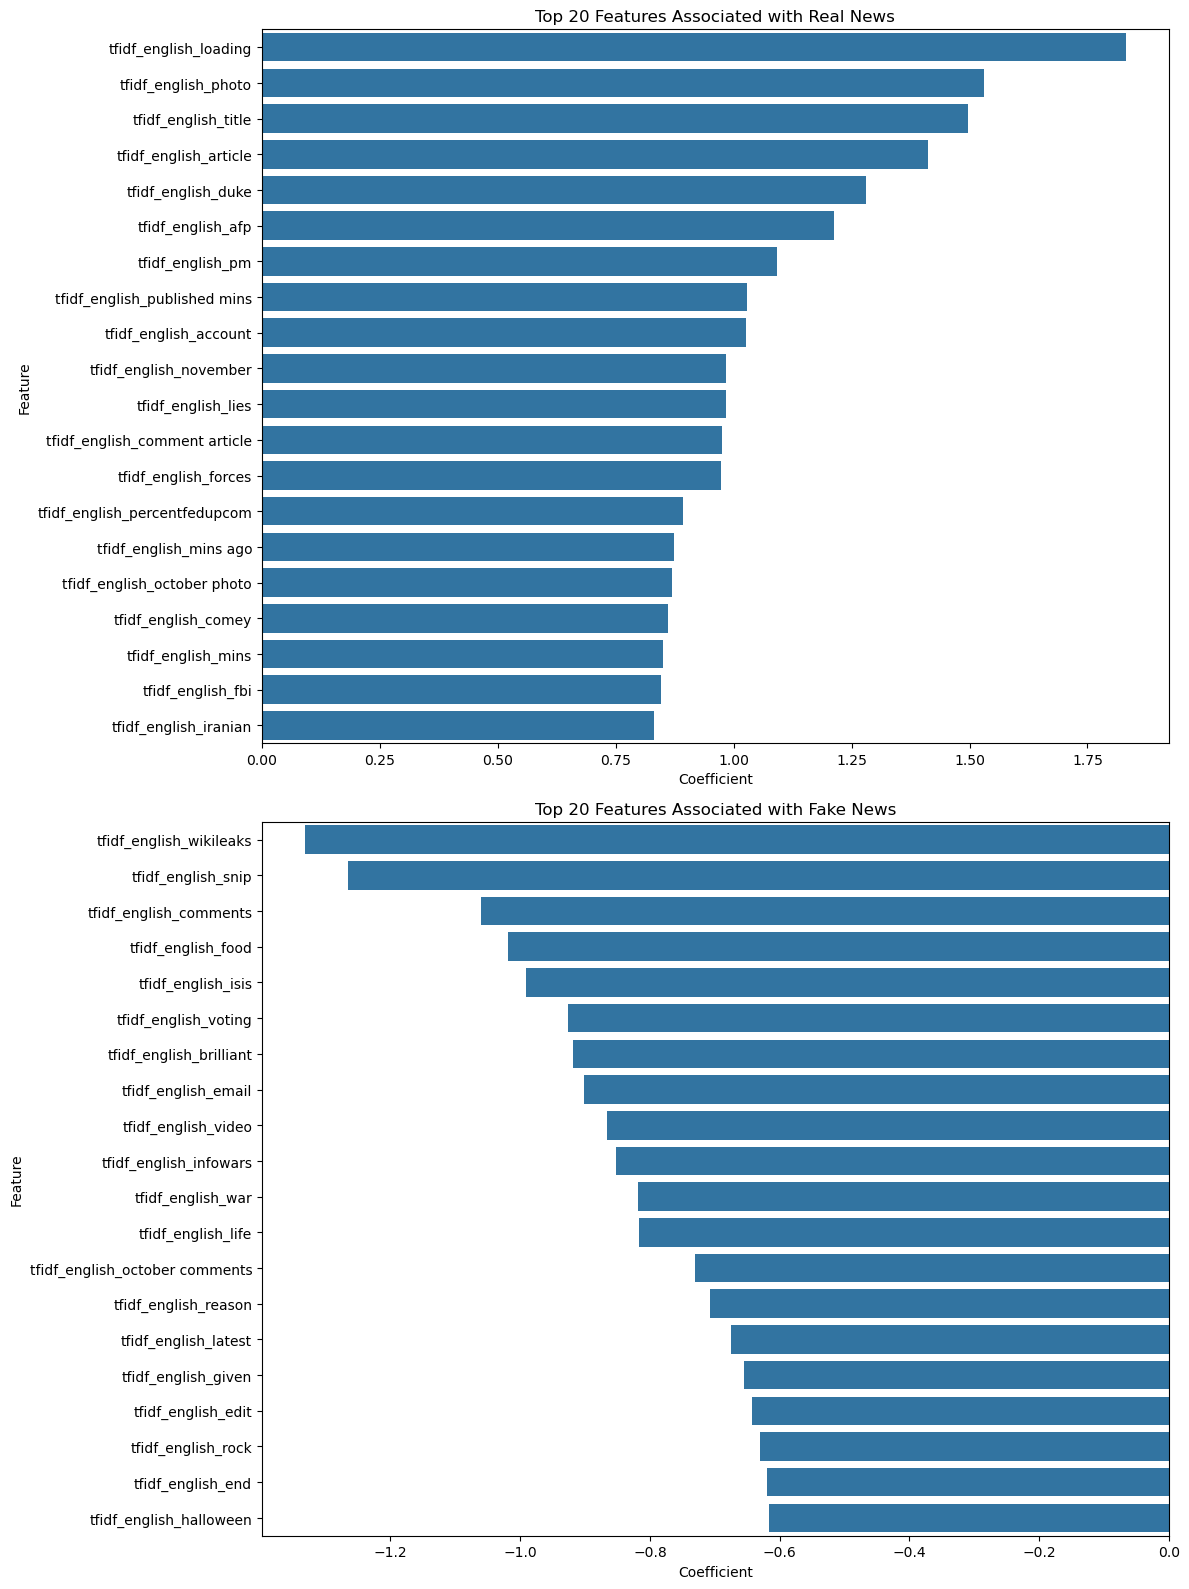

In [22]:
# Evaluate the best model on the test set
print("Evaluating the best model on the test set...")

# Get the best model
best_model = final_models[best_model_name]

# Get the appropriate test features
if '1-gram' in best_model_name:
    X_test = test_tfidf_1gram.fillna(0).values
else:  # '1-2 gram'
    X_test = test_tfidf_2gram.fillna(0).values

# Make predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of 'Real' class

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, y_test_prob)

# Print test results
print(f"\nTest results for {best_model_name}:")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall: {test_recall:.4f}")
print(f"  Test F1: {test_f1:.4f}")
print(f"  Test ROC AUC: {test_roc_auc:.4f}")

# Generate and print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Fake', 'Real'],
           yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.tight_layout()
plt.show()

# Get feature importances for the best model (if applicable)
if 'Random Forest' in best_model_name:
    # Get feature names
    if '1-gram' in best_model_name:
        feature_names = tfidf_1gram.columns
    else:  # '1-2 gram'
        feature_names = tfidf_2gram.columns
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create a DataFrame of feature importances
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False)
    
    # Display the top 20 features
    print("\nTop 20 Most Important Features:")
    print(feature_imp_df.head(20))
    
    # Visualize top 20
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20))
    plt.title(f'Top 20 Most Important Features for {best_model_name}')
    plt.tight_layout()
    plt.show()
elif 'Logistic Regression' in best_model_name:
    # For Logistic Regression, we can look at the coefficients
    # Get feature names
    if '1-gram' in best_model_name:
        feature_names = tfidf_1gram.columns
    else:  # '1-2 gram'
        feature_names = tfidf_2gram.columns
    
    # Get coefficients
    coef = best_model.coef_[0]
    
    # Create a DataFrame of coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Display the top 20 features (highest absolute coefficients)
    print("\nTop 20 Most Influential Features:")
    print(coef_df.head(20)[['Feature', 'Coefficient']])
    
    # Visualize top 20 (positive and negative)
    plt.figure(figsize=(12, 16))
    
    # Top positive coefficients
    plt.subplot(2, 1, 1)
    top_pos = coef_df[coef_df['Coefficient'] > 0].head(20)
    sns.barplot(x='Coefficient', y='Feature', data=top_pos)
    plt.title(f'Top 20 Features Associated with Real News')
    
    # Top negative coefficients
    plt.subplot(2, 1, 2)
    top_neg = coef_df[coef_df['Coefficient'] < 0].head(20)
    sns.barplot(x='Coefficient', y='Feature', data=top_neg)
    plt.title(f'Top 20 Features Associated with Fake News')
    
    plt.tight_layout()
    plt.show()

Creating performance summary for all models...
Structure of results object:
<class 'float'>

Using validation_results to build the summary:
validation_results has 4 entries

Model Performance Summary:
                                   Model  Validation Accuracy  Validation Precision  Validation Recall  Validation F1  Validation ROC AUC  \
0          Random Forest - 1-gram TF-IDF             0.764128              0.747748           0.549669       0.633588            0.835019   
1        Random Forest - 1-2 gram TF-IDF             0.783784              0.853933           0.503311       0.633333            0.860643   
2    Logistic Regression - 1-gram TF-IDF             0.759214              0.693431           0.629139       0.659722            0.830971   
3  Logistic Regression - 1-2 gram TF-IDF             0.783784              0.736842           0.649007       0.690141            0.848484   

   Test Accuracy  Test Precision  Test Recall   Test F1  Test ROC AUC  
0            NaN     

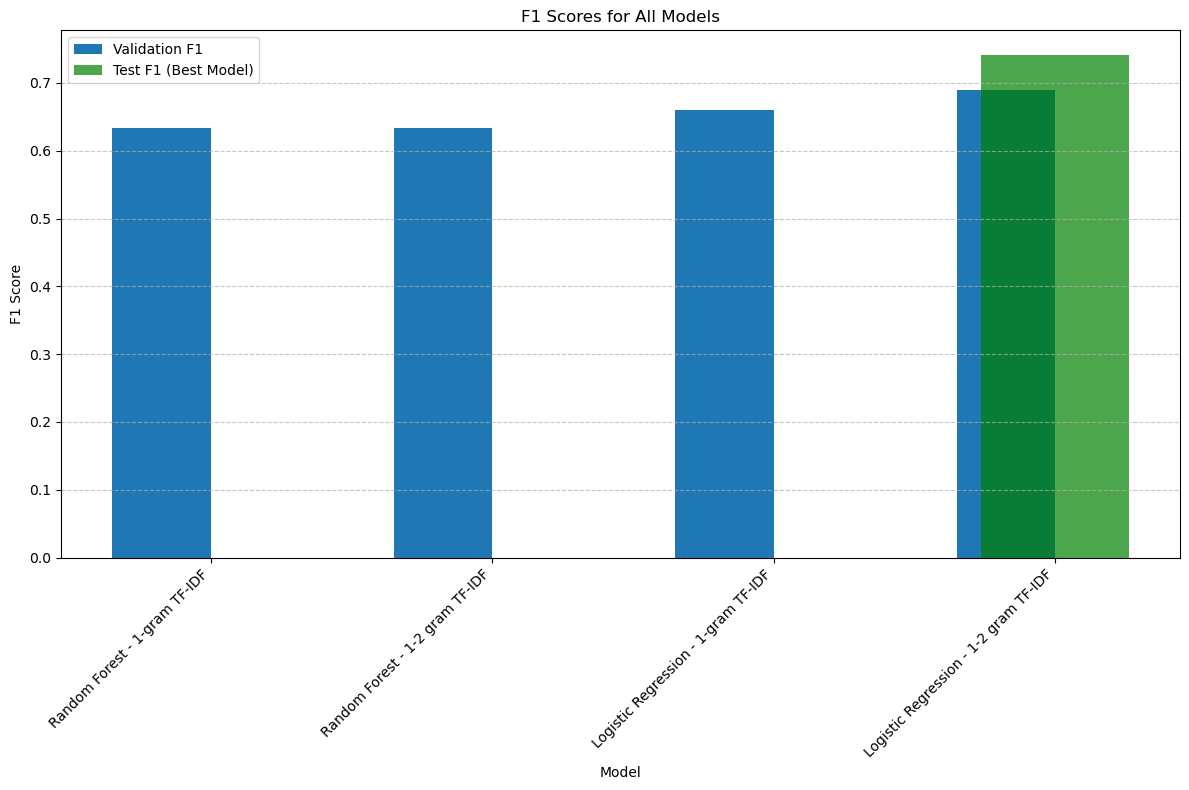

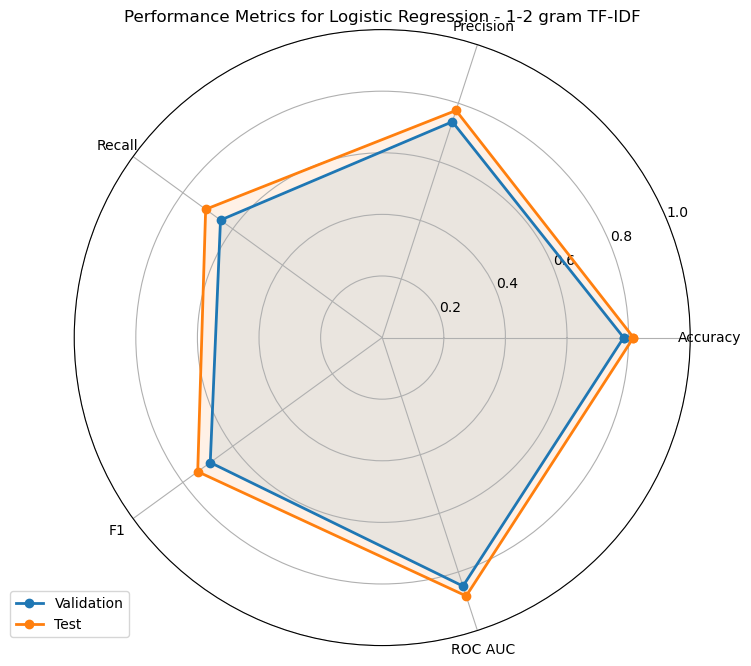


Final Conclusions and Recommendations:
1. The best performing model is Logistic Regression - 1-2 gram TF-IDF with an F1 score of 0.7405 on the test set.
2. This model achieved test accuracy of 0.8157, precision of 0.7754, and recall of 0.7086.
3. Key findings from feature importance analysis:
   - Top features indicative of REAL news:
     * loading (coefficient: 1.8312)
     * photo (coefficient: 1.5306)
     * title (coefficient: 1.4970)
     * article (coefficient: 1.4112)
     * duke (coefficient: 1.2796)
   - Top features indicative of FAKE news:
     * wikileaks (coefficient: -1.3316)
     * snip (coefficient: -1.2658)
     * comments (coefficient: -1.0605)
     * food (coefficient: -1.0190)
     * isis (coefficient: -0.9908)


In [28]:
# Create a summary of model performance
print("Creating performance summary for all models...")

# First, let's examine the structure of the results object
print("Structure of results object:")
print(type(results))

# Create a new dictionary to store our summary data
summary_data = []

# Since results is a float, we'll create our summary from validation_results
print("\nUsing validation_results to build the summary:")
if isinstance(validation_results, dict):
    print(f"validation_results has {len(validation_results)} entries")
    
    # Create entries from validation results
    for model_name, val_results in validation_results.items():
        row = {
            'Model': model_name,
            'Validation Accuracy': val_results.get('accuracy', float('nan')),
            'Validation Precision': val_results.get('precision', float('nan')),
            'Validation Recall': val_results.get('recall', float('nan')),
            'Validation F1': val_results.get('f1', float('nan')),
            'Validation ROC AUC': val_results.get('roc_auc', float('nan'))
        }
        summary_data.append(row)
else:
    print("Warning: validation_results is not a dictionary")
    # Create placeholder entries for each model-feature combination
    for model_name in models:
        for feature_name in feature_sets:
            model_key = f"{model_name} - {feature_name}"
            summary_data.append({'Model': model_key})

# Add test results for the best model
for row in summary_data:
    if row['Model'] == best_model_name:
        row.update({
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1': test_f1,
            'Test ROC AUC': test_roc_auc
        })

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# Reorder columns
column_order = [
    'Model', 
    'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1', 'Validation ROC AUC',
    'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC AUC'
]
summary_df = summary_df.reindex(columns=[col for col in column_order if col in summary_df.columns])

# Display the summary
print("\nModel Performance Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 150)  # Set width to avoid wrapping
print(summary_df)

# Create visualizations for performance comparison
metrics = ['F1', 'Accuracy', 'Precision', 'Recall', 'ROC AUC']
val_metrics = [f'Validation {m}' for m in metrics if f'Validation {m}' in summary_df.columns]

# Plot F1 scores for all models
plt.figure(figsize=(12, 8))
bar_width = 0.35
x = np.arange(len(summary_df))

# Plot Validation F1 scores if available
if 'Validation F1' in summary_df.columns and not summary_df['Validation F1'].isna().all():
    plt.bar(x - bar_width/2, summary_df['Validation F1'].fillna(0), width=bar_width, label='Validation F1')

# Highlight the best model's test F1 (if available)
if 'Test F1' in summary_df.columns and not summary_df['Test F1'].isna().all():
    best_idx = summary_df.index[summary_df['Model'] == best_model_name].tolist()[0]
    if not pd.isna(summary_df.loc[best_idx, 'Test F1']):
        plt.bar(best_idx, summary_df.loc[best_idx, 'Test F1'], width=bar_width*1.5, 
                color='green', alpha=0.7, label='Test F1 (Best Model)')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores for All Models')
plt.xticks(x, summary_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Define categories for the radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

# Create a radar chart comparing the best model's performance
if 'Test F1' in summary_df.columns and not summary_df['Test F1'].isna().all():
    best_model_idx = summary_df.index[summary_df['Model'] == best_model_name].tolist()[0]
    
    # Check if we have data for both sets (Validation and Test)
    has_val = any([f'Validation {cat}' in summary_df.columns and not pd.isna(summary_df.loc[best_model_idx, f'Validation {cat}']) for cat in categories])
    has_test = any([f'Test {cat}' in summary_df.columns and not pd.isna(summary_df.loc[best_model_idx, f'Test {cat}']) for cat in categories])
    
    if has_val or has_test:
        plt.figure(figsize=(10, 8))
        
        # Get values, using NaN for missing data
        values_val = [summary_df.loc[best_model_idx, f'Validation {cat}'] if f'Validation {cat}' in summary_df.columns else float('nan') for cat in categories]
        values_test = [summary_df.loc[best_model_idx, f'Test {cat}'] if f'Test {cat}' in summary_df.columns else float('nan') for cat in categories]
        
        # Fill NaN values with 0 for plotting
        values_val = np.array([v if not pd.isna(v) else 0 for v in values_val])
        values_test = np.array([v if not pd.isna(v) else 0 for v in values_test])
        
        # Number of variables
        N = len(categories)
        
        # We need to repeat the first value to close the circle
        values_val = np.append(values_val, values_val[0])
        values_test = np.append(values_test, values_test[0])
        categories_circ = np.append(categories, categories[0])
        
        # Angle for each category
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the circle
        
        # Set up the plot
        ax = plt.subplot(111, polar=True)
        
        # Draw the lines
        if has_val:
            plt.plot(angles, values_val, 'o-', linewidth=2, label='Validation')
            plt.fill(angles, values_val, alpha=0.1)
        if has_test:
            plt.plot(angles, values_test, 'o-', linewidth=2, label='Test')
            plt.fill(angles, values_test, alpha=0.1)
        
        # Set the category labels
        plt.xticks(angles[:-1], categories_circ[:-1])
        
        # Set the limit of y-axis
        plt.ylim(0, 1)
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        plt.title(f'Performance Metrics for {best_model_name}')
        plt.show()

# Final summary and recommendations
print("\nFinal Conclusions and Recommendations:")
print(f"1. The best performing model is {best_model_name} with an F1 score of {test_f1:.4f} on the test set.")
print(f"2. This model achieved test accuracy of {test_accuracy:.4f}, precision of {test_precision:.4f}, and recall of {test_recall:.4f}.")
print("3. Key findings from feature importance analysis:")

if 'Logistic Regression' in best_model_name:
    # Get coefficient dataframe
    if '1-gram' in best_model_name:
        feature_names = tfidf_1gram.columns
    else:  # '1-2 gram'
        feature_names = tfidf_2gram.columns
    
    coef = best_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef
    })
    
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Print top 5 features for real news
    top_real = coef_df[coef_df['Coefficient'] > 0].head(5)
    print("   - Top features indicative of REAL news:")
    for _, row in top_real.iterrows():
        feature = row['Feature'].split('_')[-1] if '_' in row['Feature'] else row['Feature']
        print(f"     * {feature} (coefficient: {row['Coefficient']:.4f})")
    
    # Print top 5 features for fake news
    top_fake = coef_df[coef_df['Coefficient'] < 0].head(5)
    print("   - Top features indicative of FAKE news:")
    for _, row in top_fake.iterrows():
        feature = row['Feature'].split('_')[-1] if '_' in row['Feature'] else row['Feature']
        print(f"     * {feature} (coefficient: {row['Coefficient']:.4f})")

In [29]:
# Create a function to predict whether a news article is real or fake
def predict_news_authenticity(title, text, language='english'):
    """
    Predicts whether a news article is real or fake using our best model
    
    Parameters:
    -----------
    title : str
        The title of the news article
    text : str
        The text/content of the news article
    language : str, default='english'
        The language of the news article
    
    Returns:
    --------
    dict
        A dictionary containing the prediction, probability, and explanation
    """
    # Preprocess the input text
    processed_title = preprocess_text(title, language)
    processed_text = preprocess_text(text, language)
    combined_text = processed_title + ' ' + processed_text
    
    # Create a DataFrame with the required columns
    news_df = pd.DataFrame({
        'title': [title],
        'text': [text],
        'language': [language],
        'combined_text': [combined_text]
    })
    
    # Get the best model and relevant vectorizers
    best_model = final_models[best_model_name]
    
    # Apply the appropriate vectorizers based on the best model
    if '1-gram' in best_model_name:
        vectorizers_to_use = vectorizers_1gram
    else:  # '1-2 gram'
        vectorizers_to_use = vectorizers_2gram
    
    # Transform the input text
    features = apply_language_tfidf_vectorizers(news_df, vectorizers_to_use)
    features = features.fillna(0).values
    
    # Get predictions
    prediction = best_model.predict(features)[0]
    probability = best_model.predict_proba(features)[0]
    
    # Prepare the result
    result = {
        'prediction': 'Real' if prediction == 1 else 'Fake',
        'probability': probability[1] if prediction == 1 else probability[0],
        'confidence': f"{max(probability) * 100:.2f}%",
    }
    
    # If it's Logistic Regression, include feature importance analysis
    if 'Logistic Regression' in best_model_name:
        # Get coefficients
        if '1-gram' in best_model_name:
            feature_names = tfidf_1gram.columns
        else:  # '1-2 gram'
            feature_names = tfidf_2gram.columns
        
        coef = best_model.coef_[0]
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coef
        })
        
        # Sort by absolute coefficient value
        coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
        coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        # Extract words from features
        def extract_word(feature_name):
            if '_' in feature_name:
                parts = feature_name.split('_')
                return parts[-1] if len(parts) >= 3 else feature_name
            return feature_name
        
        coef_df['Word'] = coef_df['Feature'].apply(extract_word)
        
        # Find features that appear in the input text
        words_in_text = []
        combined_text_lower = combined_text.lower()
        
        for _, row in coef_df.head(100).iterrows():
            word = row['Word'].lower()
            if word in combined_text_lower:
                words_in_text.append({
                    'word': row['Word'],
                    'coefficient': row['Coefficient'],
                    'impact': 'Real news indicator' if row['Coefficient'] > 0 else 'Fake news indicator'
                })
                if len(words_in_text) >= 5:
                    break
        
        result['influential_words'] = words_in_text
    
    return result

# Test the function with a few examples
print("Testing our fake news detection model with example articles...")

# Example 1: A real news article
real_news_title = "Senate Passes New Healthcare Bill After Long Debate"
real_news_text = """
The Senate passed a comprehensive healthcare bill today after months of debate. 
The bill, which aims to lower prescription drug costs and expand coverage for millions of Americans,
received bipartisan support with a vote of 68-32. The legislation will now move to the House for consideration.
President's office released a statement supporting the bill's passage.
"""

# Example 2: A fake news article
fake_news_title = "Government Secretly Installing Mind Control Devices in COVID Vaccines"
fake_news_text = """
SHOCKING TRUTH REVEALED!!! Government scientists have been caught installing microscopic mind control 
chips in the COVID vaccines. According to an anonymous whistleblower, these chips connect to 5G networks
and allow the government to control your thoughts. Share this before it gets deleted!!!
"""

# Example 3: An ambiguous article
ambiguous_title = "New Study Shows Surprising Results About Diet"
ambiguous_text = """
A new study published online suggests that certain foods might have unexpected effects on health.
The research, conducted by food industry scientists, indicates potential benefits for consumers.
Critics say more independent research is needed to verify the claims.
"""

# Process the examples
examples = [
    {"title": real_news_title, "text": real_news_text, "expected": "Real"},
    {"title": fake_news_title, "text": fake_news_text, "expected": "Fake"},
    {"title": ambiguous_title, "text": ambiguous_text, "expected": "Unknown"}
]

# Display results
for i, example in enumerate(examples):
    print(f"\nExample {i+1} ({example['expected']}):")
    print(f"Title: {example['title']}")
    print(f"Text: {example['text'][:100]}...")
    
    # Get prediction
    try:
        result = predict_news_authenticity(example['title'], example['text'])
        
        # Display prediction
        print(f"\nPrediction: {result['prediction']} (Confidence: {result['confidence']})")
        
        # Display influential words
        if 'influential_words' in result and result['influential_words']:
            print("\nInfluential words in this text:")
            for word_info in result['influential_words']:
                print(f"  - '{word_info['word']}': {word_info['impact']} (coefficient: {word_info['coefficient']:.4f})")
    except Exception as e:
        print(f"Error making prediction: {e}")

# Summary
print("\n----------------------------------------------------------------")
print("Summary of Fake News Detection Model")
print("----------------------------------------------------------------")
print(f"1. Best model: {best_model_name}")
print(f"2. Test accuracy: {test_accuracy:.4f}")
print(f"3. Test F1 score: {test_f1:.4f}")
print("\nThe model identifies fake news by analyzing the words and phrases used in the title and text.")
print("It particularly looks for language patterns that are commonly associated with either legitimate or misleading news.")
print("\nLimitations:")
print("- The model may not perform as well on news from domains it wasn't trained on")
print("- It relies heavily on textual patterns and may miss sophisticated fake news with realistic language")
print("- Performance varies by language, with better results for languages well-represented in the training data")

Testing our fake news detection model with example articles...

Example 1 (Real):
Title: Senate Passes New Healthcare Bill After Long Debate
Text: 
The Senate passed a comprehensive healthcare bill today after months of debate. 
The bill, which ai...
  Transforming language: english with 1 samples

Prediction: Fake (Confidence: 55.32%)

Influential words in this text:
  - 'dr': Real news indicator (coefficient: 0.6974)
  - 'cover': Real news indicator (coefficient: 0.5916)

Example 2 (Fake):
Title: Government Secretly Installing Mind Control Devices in COVID Vaccines
Text: 
SHOCKING TRUTH REVEALED!!! Government scientists have been caught installing microscopic mind contr...
  Transforming language: english with 1 samples

Prediction: Fake (Confidence: 63.27%)

Example 3 (Unknown):
Title: New Study Shows Surprising Results About Diet
Text: 
A new study published online suggests that certain foods might have unexpected effects on health.
T...
  Transforming language: english with 1 samp